---

# TensorFlow 2.0 Question Answering
#### Identify the answers to real user questions about Wikipedia page content 

---

### **Problem Statement**

The aim of the  [TensorFlow 2.0 Question Answering](https://www.kaggle.com/competitions/tensorflow2-question-answering/overview) project is to develop a machine learning model that can answer questions based on Wikipedia articles. The model is expected to identify the correct long answer to a question from a given Wikipedia article, and then extract the relevant short answer from the long answer. The project is part of a Kaggle competition that provides a dataset of Wikipedia articles, questions, and answers for training and testing the model. The goal is to develop a model that can achieve high accuracy in answering questions from the test set. The dataset is provided by [Google's Natural Questions](https://ai.google.com/research/NaturalQuestions/dataset) , but contains its own unique private test set. A [visualization](https://ai.google.com/research/NaturalQuestions/visualization) of examples shows long and—where available—short answers.



### [Data Fields](https://www.kaggle.com/competitions/tensorflow2-question-answering/data)

- `document_text` - the text of the article in question (with some HTML tags to provide document structure). The text can be tokenized by splitting on whitespace.

- `question_text` - the question to be answered

- `long_answer_candidates` - a JSON array containing all of the plausible long answers.

- `annotations` - a JSON array containing all of the correct long + short answers. Only provided for train.

- `document_url` - the URL for the full article. Provided for informational purposes only. This is NOT the simplified version of the article so indices from this cannot be used directly. The content may also no longer match the html used to generate document_text. Only provided for train.

- `example_id` - unique ID for the sample.


---
### Table of Contents

- 1. Importing the Required Libraries
       
- 2. Load Data

- 3. Exploratory Data Analysis 

- 4. Part 1 - Identifying Correct Long Answer to a Question

   - 5. Texts Pre-processing
   - 6. Define Embedding Layer (Using GloVe)
   - 7. Defining Model
   - 8. Model Evaluation

- 9. Part 2 - Extracting Short Answer from a Long Answer

  - 10. Defining Model
  - 11. Model Evaluation

- 12. End Notes
---


In this notebook to build a model using TensorFlow 2.0 to answer user questions about Wikipedia page content. The model should be able to identify the correct long answer to a question and extract the short answer from the long answer.

## 1. Importing the Required Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tensorflow2-question-answering/simplified-nq-train.jsonl
/kaggle/input/tensorflow2-question-answering/sample_submission.csv
/kaggle/input/tensorflow2-question-answering/simplified-nq-test.jsonl
/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt


In [2]:
# Provides functions for working with JSON data.
import json
# tqdm module, which provides a progress bar to track the progress of a loop or iterator.
from tqdm.notebook import tqdm
# matplotlib module, specifically the pyplot sub-module, which provides functions for creating various types of plots and charts.
import matplotlib.pyplot as plt
# seaborn module, which provides functions for creating statistical graphics and data visualizations.
import seaborn as sns

# re module, which provides functions for working with regular expressions.
import re
# gc module, which provides functions for working with Python's garbage collector.
import gc
# tensorflow module, which is a popular open-source platform for building and training machine learning models.
import tensorflow as tf

# stopwords module from the Natural Language Toolkit (nltk), which provides a list of stop words commonly used in the English language.
from nltk.corpus import stopwords
# CountVectorizer and TfidfVectorizer classes from the feature_extraction.text module of the sklearn library. These classes are used for extracting features from text data.
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# imports several classes and functions from the Keras API within TensorFlow. 
# These are specific layers and functions used to build deep learning models for natural language processing tasks. 
# The layers include LSTM, Bidirectional, GlobalMaxPooling1D, SpatialDropout1D, Dense, Dropout, Input, concatenate, Conv1D, Activation, and Flatten.
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, SpatialDropout1D, Dense, Dropout, Input, concatenate, Conv1D, Activation, Flatten

## 2. Load Data

In [3]:
#reading data
sample_submission = pd.read_csv("../input/tensorflow2-question-answering/sample_submission.csv")
sample_submission.head(20)

,example_id,PredictionString
0,-1011141123527297803_long,NaN
1,-1011141123527297803_short,NaN
2,-1028916936938579349_long,NaN
3,-1028916936938579349_short,NaN
4,-1055197305756217938_long,NaN
5,-1055197305756217938_short,NaN
6,-1074129516932871805_long,NaN
7,-1074129516932871805_short,NaN
8,-1114334749483663139_long,NaN
9,-1114334749483663139_short,NaN


In [4]:
#path for data files
train_path = '../input/tensorflow2-question-answering/simplified-nq-train.jsonl'
test_path = '../input/tensorflow2-question-answering/simplified-nq-test.jsonl'

The **chunksize** parameter is often used when working with large datasets, as it allows the program to load the data in smaller increments and perform analysis or transformations on each chunk before moving on to the next one. This can help to reduce memory usage and improve the overall performance of the program.

In [5]:
# read in chunks of 2000 lines at a time
chunksize=2000

In [6]:
#read a sample of data files
def read_data(path, sample = True, chunksize = chunksize):
    if sample == True:
        df = []
        with open(path, 'r') as reader:
            for i in range(chunksize):
                df.append(json.loads(reader.readline()))
        df = pd.DataFrame(df)
        print('Sample data have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
    else:
        df = pd.read_json(path, orient = 'records', lines = True)
        print('Sample data have {} rows and {} columns'.format(df.shape[0], df.shape[1]))
        gc.collect()
    return df

train = read_data(train_path, sample = True)
test = read_data(test_path, sample = False)
train.head()

Sample data have 2000 rows and 6 columns
Sample data have 346 rows and 4 columns


,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


## 3. Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an important step in any data science project, including a TensorFlow 2.0 Question Answering project. EDA allows you to gain a better understanding of the dataset you are working with, identify patterns and trends, and potentially discover issues such as missing values or outliers that need to be addressed.

For a Question Answering project, EDA can help you identify the distribution of question types, the distribution of answer lengths, and any relationships between the questions and answers. This information can be useful for developing and fine-tuning your model, as well as identifying potential biases in the dataset.

Additionally, EDA can help you identify any issues with the data that may affect the accuracy of your model, such as inconsistent formatting or ambiguous or poorly worded questions. By identifying these issues early on, you can take steps to address them and improve the overall quality of your dataset.

In [7]:
#read in and access data from a DataFrame object
df = read_data(train_path, sample = True)
print(df['question_text'][1])
print(df['annotations'][1])

Sample data have 2000 rows and 6 columns
how i.met your mother who is the mother
[{'yes_no_answer': 'NONE', 'long_answer': {'start_token': 212, 'candidate_index': 15, 'end_token': 310}, 'short_answers': [{'start_token': 213, 'end_token': 215}], 'annotation_id': 12034874153783787365}]


Text(0.5, 1.0, 'Distribution of text word count of 2000 documents')

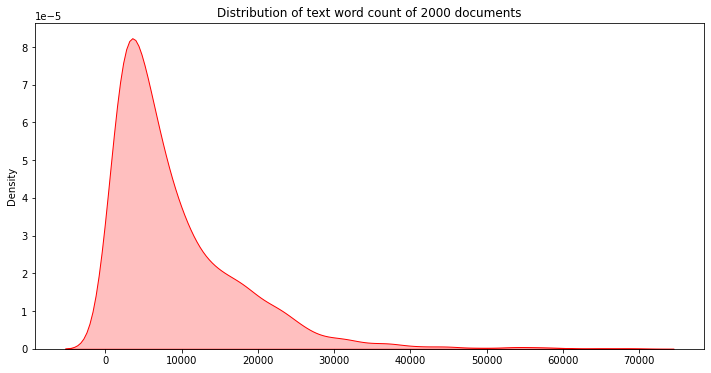

In [8]:
#check the distribution of word count in sample 10000 documents
doc_text_words = df['document_text'].apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(12,6))
sns.kdeplot(doc_text_words.values,shade=True, color="r").set_title('Distribution of text word count of ' + str(chunksize) + ' documents')

In [9]:
#long_answer_candidates
df.long_answer_candidates[0][:5]

[{'start_token': 14, 'top_level': True, 'end_token': 170},
 {'start_token': 15, 'top_level': False, 'end_token': 169},
 {'start_token': 52, 'top_level': False, 'end_token': 103},
 {'start_token': 53, 'top_level': False, 'end_token': 102},
 {'start_token': 103, 'top_level': False, 'end_token': 156}]

In [10]:
#data is how formatted and what types of information it contains
df.annotations[1][:100]

[{'yes_no_answer': 'NONE',
  'long_answer': {'start_token': 212, 'candidate_index': 15, 'end_token': 310},
  'short_answers': [{'start_token': 213, 'end_token': 215}],
  'annotation_id': 12034874153783787365}]

In [11]:
df.question_text[1][:100]

'how i.met your mother who is the mother'

In [12]:
df.document_text[3][:100]

'List of National Football League career quarterback wins leaders - wikipedia <H1> List of National F'

In [13]:
#check long_answers_distribution
def preprocess_data():
    df = read_data(train_path, sample = True)
    df['yes_no'] = df.annotations.apply(lambda x: x[0]['yes_no_answer'])
    df['long'] = df.annotations.apply(lambda x: [x[0]['long_answer']['start_token'], x[0]['long_answer']['end_token']])
    df['short'] = df.annotations.apply(lambda x: x[0]['short_answers'])
    return df
df = preprocess_data()
df

Sample data have 2000 rows and 6 columns


,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,yes_no,long,short
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,NONE,"[1952, 2019]","[{'start_token': 1960, 'end_token': 1969}]"
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,NONE,"[212, 310]","[{'start_token': 213, 'end_token': 215}]"
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852,NONE,"[319, 438]",[]
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439,NONE,"[509, 576]","[{'start_token': 512, 'end_token': 514}]"
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018,NONE,"[-1, -1]",[]
...,...,...,...,...,...,...,...,...,...
1995,Grace and Frankie - Wikipedia <H1> Grace and F...,"[{'start_token': 10, 'top_level': True, 'end_t...",how long is each grace and frankie episode,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Gr...,-7716384782891686197,NONE,"[10, 399]","[{'start_token': 300, 'end_token': 304}]"
1996,Cellular respiration - wikipedia <H1> Cellular...,"[{'start_token': 10, 'top_level': True, 'end_t...",after complete oxidation of a glucose molecule...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ce...,8933277615800380148,NONE,"[780, 883]","[{'start_token': 796, 'end_token': 799}]"
1997,Some Like It Hot ( song ) - wikipedia <H1> Som...,"[{'start_token': 18, 'top_level': True, 'end_t...",who sings the song some like it hot,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=So...,-6909007989280228395,NONE,"[-1, -1]",[]
1998,Princes in the Tower - wikipedia <H1> Princes ...,"[{'start_token': 44, 'top_level': True, 'end_t...",who killed the twins in the tower of london,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Pr...,1501574334625895729,NONE,"[-1, -1]",[]


In [14]:
df['yes_no'].value_counts()

NONE    1977
YES       17
NO         6
Name: yes_no, dtype: int64

In [15]:
# filter the answers that exist
df_ans_exists = df.long.apply(lambda x: "Answer Doesn't exist" if x == -1 else "Answer Exists") == "Answer Exists"
df_ans_exists.count()

2000

In [16]:
#check if there are questions that do not have an answer
display(df.long.apply(lambda x: "Answer Doesn't exist" if x[0] == -1 else "Answer Exists").value_counts(normalize=True))

Answer Exists           0.519
Answer Doesn't exist    0.481
Name: long, dtype: float64

In [17]:
#check the dstribution of Yes and No Answers
yes_no_dist = df[df_ans_exists].yes_no.value_counts(normalize=True)
display(yes_no_dist)

NONE    0.9885
YES     0.0085
NO      0.0030
Name: yes_no, dtype: float64

Text(0.5, 1.0, 'Distribution of short answers in answerable questions')

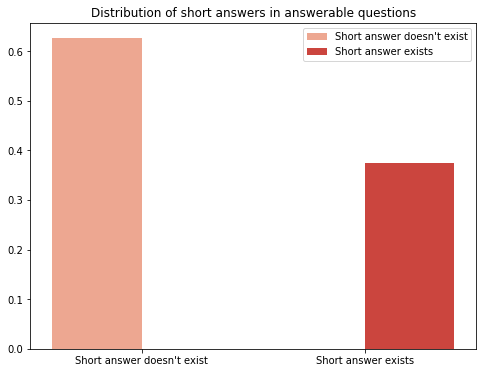

In [18]:
#checking the distribution of short answers
short_dist = df[df_ans_exists].short.apply(lambda x: "Short answer exists" if len(x) > 0 else "Short answer doesn't exist").value_counts(normalize=True)
plt.figure(figsize=(8,6))
sns.barplot(x=short_dist.index,y=short_dist.values,hue=short_dist.index,palette = "Reds").set_title("Distribution of short answers in answerable questions")

Text(0.5, 1.0, 'Distribution of Number of Short Answers in answerable questions')

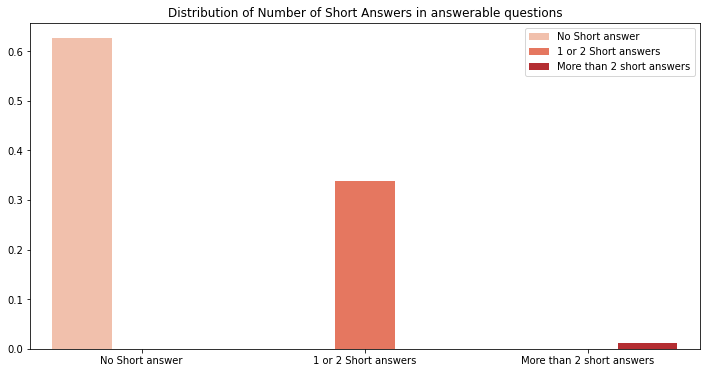

In [19]:
#generates a bar plot that shows the distribution of the number of short answers for questions that have at least one short answer in a dataset.
short_ans_dist = df[df_ans_exists].short.apply(len).value_counts(normalize=True)
short_ans_dist = pd.concat([short_ans_dist.loc[[0,1,],], pd.Series(short_ans_dist.loc[3:].sum(),index=['>=3'])])
#The x-axis of the plot shows the categories of short answers, such as "No Short answer", "1 or 2 Short answers", and "More than 2 short answers", while the y-axis shows the proportion of questions in the dataset that belong to each category.
short_ans_dist = short_ans_dist.rename(index={0: 'No Short answer',1:"1 or 2 Short answers",">=3":"More than 2 short answers"})
plt.figure(figsize=(12,6))
# The color of the bars corresponds to the category labels, and the title of the plot describes what it is showing.
sns.barplot(x=short_ans_dist.index,y=short_ans_dist.values,hue=short_ans_dist.index,palette = "Reds").set_title("Distribution of Number of Short Answers in answerable questions")

In [20]:
#check if there are missing data in the datasets

#defines a function called check_missing_data that takes a DataFrame as input and checks if there are any missing values in it.
def check_missing_data(df):
    missing_value=df.isna().sum().any()
    if missing_value==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
#If there are any missing values, the function computes the total number of missing values, the percentage of missing values, and the data types of the columns containing missing values, and returns a summary table.
#If there are no missing values, the function returns False. The function is called twice, once for a train DataFrame and once for a test DataFrame, and the results are printed to the console indicating whether missing data exists in each of the data sets.
        for col in df.columns:
            dtype = str(train[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)
    
print("Missing data exists in train set: ",check_missing_data(train))
print("Missing data exists in test set: ",check_missing_data(test))

Missing data exists in train set:  False
Missing data exists in test set:  False


In [21]:
#check count values in each column
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [22]:
count_values_in_column(df,'yes_no')

,Total,Percentage
NONE,1977,98.85
YES,17,0.85
NO,6,0.30


In [23]:
#count unique values in each column
def unique_values_in_column(data,feature):
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

In [24]:
unique_values_in_column(df,'document_text')

,Unique Values
0,Email marketing - Wikipedia <H1> Email marketi...
1,The Mother ( How I Met Your Mother ) - wikiped...
2,Human fertilization - wikipedia <H1> Human fer...
3,List of National Football League career quarte...
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...
...,...
1987,Grace and Frankie - Wikipedia <H1> Grace and F...
1988,Cellular respiration - wikipedia <H1> Cellular...
1989,Some Like It Hot ( song ) - wikipedia <H1> Som...
1990,Princes in the Tower - wikipedia <H1> Princes ...


In [25]:
#find duplicated values in each column
def duplicated_values_data(data):
    dup=[]
    columns=data.columns
    for i in data.columns:
        dup.append(sum(data[i].duplicated()))
    return pd.concat([pd.Series(columns),pd.Series(dup)],axis=1,keys=['Columns','Duplicate count'])

In [26]:
duplicated_values_data(df)

,Columns,Duplicate count
0,document_text,8
1,long_answer_candidates,11
2,question_text,0
3,annotations,0
4,document_url,10
5,example_id,0
6,yes_no,1997
7,long,968
8,short,1283


In [27]:
df.describe()

,example_id
count,2.000000e+03
mean,-2.083664e+17
std,5.309581e+18
min,-9.209840e+18
25%,-4.901767e+18
50%,-2.302742e+17
75%,4.276727e+18
max,9.208620e+18


In [28]:
#remove hash texts in questions
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)

In [29]:
df['hash']=df['question_text'].apply(lambda x: find_hash(x))


In [30]:
df['hash'].value_counts()

    2000
Name: hash, dtype: int64

In [31]:
unique_values_in_column(df,'hash').value_counts()

Unique Values
                 1
dtype: int64

In [33]:
# df['hash'] = df['hash'].fillna(df['document_text'])
df.loc[df['hash'].str.strip() == '', 'hash'] = df['document_text']

In [34]:
df

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,yes_no,long,short,hash
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,NONE,"[1952, 2019]","[{'start_token': 1960, 'end_token': 1969}]",Email marketing - Wikipedia <H1> Email marketi...
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,NONE,"[212, 310]","[{'start_token': 213, 'end_token': 215}]",The Mother ( How I Met Your Mother ) - wikiped...
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852,NONE,"[319, 438]",[],Human fertilization - wikipedia <H1> Human fer...
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439,NONE,"[509, 576]","[{'start_token': 512, 'end_token': 514}]",List of National Football League career quarte...
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018,NONE,"[-1, -1]",[],Roanoke Colony - wikipedia <H1> Roanoke Colony...
...,...,...,...,...,...,...,...,...,...,...
1995,Grace and Frankie - Wikipedia <H1> Grace and F...,"[{'start_token': 10, 'top_level': True, 'end_t...",how long is each grace and frankie episode,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Gr...,-7716384782891686197,NONE,"[10, 399]","[{'start_token': 300, 'end_token': 304}]",Grace and Frankie - Wikipedia <H1> Grace and F...
1996,Cellular respiration - wikipedia <H1> Cellular...,"[{'start_token': 10, 'top_level': True, 'end_t...",after complete oxidation of a glucose molecule...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ce...,8933277615800380148,NONE,"[780, 883]","[{'start_token': 796, 'end_token': 799}]",Cellular respiration - wikipedia <H1> Cellular...
1997,Some Like It Hot ( song ) - wikipedia <H1> Som...,"[{'start_token': 18, 'top_level': True, 'end_t...",who sings the song some like it hot,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=So...,-6909007989280228395,NONE,"[-1, -1]",[],Some Like It Hot ( song ) - wikipedia <H1> Som...
1998,Princes in the Tower - wikipedia <H1> Princes ...,"[{'start_token': 44, 'top_level': True, 'end_t...",who killed the twins in the tower of london,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Pr...,1501574334625895729,NONE,"[-1, -1]",[],Princes in the Tower - wikipedia <H1> Princes ...


In [35]:
#remove punctuations
def find_punct(text):
    line = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string="".join(line)
    return list(string)

In [36]:
df['punctuation']=df['question_text'].apply(lambda x : find_punct(x))
df.loc[df['hash'].str.strip() == '', 'hash'] = df['question_text']

In [37]:
df

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id,yes_no,long,short,hash,punctuation
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401,NONE,"[1952, 2019]","[{'start_token': 1960, 'end_token': 1969}]",Email marketing - Wikipedia <H1> Email marketi...,"[-, -]"
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242,NONE,"[212, 310]","[{'start_token': 213, 'end_token': 215}]",The Mother ( How I Met Your Mother ) - wikiped...,[.]
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852,NONE,"[319, 438]",[],Human fertilization - wikipedia <H1> Human fer...,[]
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439,NONE,"[509, 576]","[{'start_token': 512, 'end_token': 514}]",List of National Football League career quarte...,[]
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018,NONE,"[-1, -1]",[],Roanoke Colony - wikipedia <H1> Roanoke Colony...,[]
...,...,...,...,...,...,...,...,...,...,...,...
1995,Grace and Frankie - Wikipedia <H1> Grace and F...,"[{'start_token': 10, 'top_level': True, 'end_t...",how long is each grace and frankie episode,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Gr...,-7716384782891686197,NONE,"[10, 399]","[{'start_token': 300, 'end_token': 304}]",Grace and Frankie - Wikipedia <H1> Grace and F...,[]
1996,Cellular respiration - wikipedia <H1> Cellular...,"[{'start_token': 10, 'top_level': True, 'end_t...",after complete oxidation of a glucose molecule...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ce...,8933277615800380148,NONE,"[780, 883]","[{'start_token': 796, 'end_token': 799}]",Cellular respiration - wikipedia <H1> Cellular...,[]
1997,Some Like It Hot ( song ) - wikipedia <H1> Som...,"[{'start_token': 18, 'top_level': True, 'end_t...",who sings the song some like it hot,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=So...,-6909007989280228395,NONE,"[-1, -1]",[],Some Like It Hot ( song ) - wikipedia <H1> Som...,[]
1998,Princes in the Tower - wikipedia <H1> Princes ...,"[{'start_token': 44, 'top_level': True, 'end_t...",who killed the twins in the tower of london,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Pr...,1501574334625895729,NONE,"[-1, -1]",[],Princes in the Tower - wikipedia <H1> Princes ...,[]


In [38]:
np.unique(df['punctuation'])

array([list([]), list(['&']), list(["'"]), list(["'", "'"]),
       list(['(', ')']), list(['(', ')', "'"]), list(['(', '.', ')']),
       list(['+']), list(['-']), list(['-', '(', ')']), list(['-', '-']),
       list(['-', '.', '.']), list(['.']),
       list(['.', '(', '&', ')', '(', ')']), list(['.', '.']),
       list(['.', '.', '-']), list(['/']), list(['='])], dtype=object)

In [39]:
# define training parameters 
num_train_ques = 2000
num_val_ques = 2050
sample_rate = 15

In [40]:
# define model parameters
epochs = 40
batch_size = 64
class_weights = {0: 0.5, 1: 5.}

## 4. **Part 1 - Identifying Correct Long Answer to a Question**

In [41]:
#The function, get_question_and_document, takes a row from the input DataFrame as input and returns the question text, document text split into a list of words, and the annotations for the row.
def get_question_and_document(line):
    question = line['question_text']
    text = line['document_text'].split(' ')
    annotations = line['annotations'][0]    
    return question, text, annotations

#The get_long_candidate, takes the index of a candidate, the annotations for the row, and the candidate itself as input and returns a boolean label indicating whether or not this candidate is the correct long answer for the question, as well as the starting and ending positions of the candidate in the document text.
def get_long_candidate(i, annotations, candidate):
    # check if this candidate is the correct long answer
    if i == annotations['long_answer']['candidate_index']:
        label = True
    else:
        label = False

    # get place where long answer starts and ends in the document text
    long_start = candidate['start_token']
    long_end = candidate['end_token']    
    return label, long_start, long_end

#The form_data_row, takes the question, label, document text, and starting and ending positions of the long answer as input and returns a dictionary containing this information. This function is used to create a new DataFrame containing the preprocessed data.
def form_data_row(question, label, text, long_start, long_end):
    row = {
        'question': question,
        'long_answer': ' '.join(text[long_start:long_end]),
        'is_long_answer': label,
    }    
    return row

In [42]:
#loads the data from a JSON file, and for each question, extracts the question text, document text, and annotations.
def load_data(file_path, questions_start, questions_end):
    rows = []
#It then loops through each long answer candidate, checks whether it is the correct long answer, and if not, samples it with a certain rate.    
    with open(file_path) as file:
        for i in tqdm(range(questions_start, questions_end)):
            line = file.readline()
            line = json.loads(line)
            question, text, annotations = get_question_and_document(line)
#For each sampled candidate or correct long answer, it creates a data row with the question, long answer, and whether the long answer is correct or not. 
            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True or (i % sample_rate == 0):
                    rows.append(
                        form_data_row(question, label, text, long_start, long_end)
                    )        
    return pd.DataFrame(rows)
#Finally, it returns a pandas DataFrame containing all the data rows.

In [43]:
train_df = load_data(train_path, 0, num_train_ques)
test_df = load_data(train_path, num_train_ques, num_val_ques)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [44]:
train_df.head(5)

,question,long_answer,is_long_answer
0,which is the most common use of opt-in e-mail ...,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,False
1,which is the most common use of opt-in e-mail ...,<Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...,False
2,which is the most common use of opt-in e-mail ...,<P> Email marketing has evolved rapidly alongs...,False
3,which is the most common use of opt-in e-mail ...,<Li> Advertisers can reach substantial numbers...,False
4,which is the most common use of opt-in e-mail ...,<P> A common example of permission marketing i...,True


In [45]:
test_df.head(5)

,question,long_answer,is_long_answer
0,which is the most common use of opt-in e-mail ...,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,False
1,which is the most common use of opt-in e-mail ...,<Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...,False
2,which is the most common use of opt-in e-mail ...,<P> Email marketing has evolved rapidly alongs...,False
3,which is the most common use of opt-in e-mail ...,<Li> Advertisers can reach substantial numbers...,False
4,which is the most common use of opt-in e-mail ...,<P> A common example of permission marketing i...,True


In [46]:
train_df.head(10)['long_answer']

0    <Table> <Tr> <Td> </Td> <Td> ( hide ) This art...
1    <Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...
2    <P> Email marketing has evolved rapidly alongs...
3    <Li> Advertisers can reach substantial numbers...
4    <P> A common example of permission marketing i...
5    <P> The CAN - SPAM Act of 2003 was passed by C...
6    <Table> <Tr> <Th_colspan="2"> Tracy McConnell ...
7    <P> Tracy McConnell , better known as `` The M...
8    <P> In `` Bass Player Wanted '' , the Mother p...
9    <Table> <Tr> <Td> Part of a series on </Td> </...
Name: long_answer, dtype: object

## 5. Text Pre-processing
Text pre-processing is crucial for any natural language processing (NLP) task, including question answering. It involves cleaning, normalizing, and transforming raw text data into a format that can be effectively used by machine learning models. In this project, text pre-processing is important to ensure that the input text data is in a consistent format, which can help improve the performance of the TensorFlow 2.0 question answering model. Additionally, text pre-processing techniques such as tokenization, stemming, and stopword removal can help reduce the dimensionality of the text data and improve the efficiency of the model. Overall, text pre-processing is an important step in any NLP task, including question answering with TensorFlow 2.0.

In [47]:
#cleaning texts by removing stopwords 
def remove_stopwords(sentence):
    words = sentence.split()
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

#removing html tags 
def remove_html(sentence):
    html = re.compile(r'<.*?>` `` ')
    return html.sub(r'', sentence)

#returns the pre-processed dataframe for long answers and questions
def preprocessed_df(df):
    df['long_answer'] = df['long_answer'].apply(lambda x : remove_stopwords(x))
    df['long_answer'] = df['long_answer'].apply(lambda x : remove_html(x))

    df['question'] = df['question'].apply(lambda x : remove_stopwords(x))
    df['question'] = df['question'].apply(lambda x : remove_html(x))
    
    return df

In [48]:
#Count vectorizer for N grams

def ngrams_top(corpus,ngram_range,n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

In [49]:
ngrams_top(df['question_text'],(3,3),n=10)

,text,count
0,big bang theory,6
1,orange new black,5
2,world cup semi,4
3,cup semi final,4
4,located world map,4
5,president united states,3
6,won world cup,3
7,gold does glitter,2
8,hitchhiker guide galaxy,2
9,fa cup final,2


In [50]:
train_df = preprocessed_df(train_df)
test_df = preprocessed_df(test_df)
train_df.head(5)

,question,long_answer,is_long_answer
0,common use opt-in e-mail marketing,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,False
1,common use opt-in e-mail marketing,<Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...,False
2,common use opt-in e-mail marketing,<P> Email marketing evolved rapidly alongside ...,False
3,common use opt-in e-mail marketing,<Li> Advertisers reach substantial numbers ema...,False
4,common use opt-in e-mail marketing,<P> A common example permission marketing news...,True


In [51]:
train_df['long_answer']

0        <Table> <Tr> <Td> </Td> <Td> ( hide ) This art...
1        <Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...
2        <P> Email marketing evolved rapidly alongside ...
3        <Li> Advertisers reach substantial numbers ema...
4        <P> A common example permission marketing news...
                               ...                        
19968    <Li> An episode Canadian children 's documenta...
19969    <Table> <Tr> <Th_colspan="2"> Pascal Maximus <...
19970    <Table> <Tr> <Td> `` We n't want like bird chi...
19971    <P> Pascal Maximus first appear Tangled ( 2010...
19972    <P> Maximus continues guard 's greatest steed ...
Name: long_answer, Length: 19973, dtype: object

### Tokenizing the Texts
Tokenizing the texts involves breaking down a sentence or document into individual words or tokens, which can then be further processed for various NLP tasks like sentiment analysis, language translation, and text classification. In this project, tokenizing the texts is important for creating feature vectors from the text data that can be used in machine learning algorithms to predict whether a given question has a long answer in a given document. The tokenization process will convert the text into a numerical representation that the machine learning algorithms can understand and use to make predictions.

In [52]:
# define tokenization parameters
filters = '!"''#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
lower_case = True
max_len = 500 #max lenght of a sentence input in to the model

In [53]:
#assigning a numeric index to each unique word in the dataset so that an array of integers
def define_tokenizer(series):
    sentences = pd.concat(series)    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower_case,filters=filters  )
    tokenizer.fit_on_texts(sentences)
    return tokenizer

#encoding, rest with 0 if max_len>no.of words in sentence 
def encode(sentences, tokenizer):
    encoded_sentences = tokenizer.texts_to_sequences(sentences)
    encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences,
                                                                      maxlen=max_len, padding='post')
    return encoded_sentences

In [54]:
tokenizer = define_tokenizer([train_df.long_answer,train_df.question,
                              test_df.long_answer,test_df.question])

In [55]:
tokenizer

In [56]:
# Get the training data word index
word_index = tokenizer.word_index
print('Number of Unique Tokens: %d' % len(word_index))

Number of Unique Tokens: 67075


In [57]:
list(enumerate(word_index.items()))[:50]

[(0, ('td', 1)),
 (1, ('tr', 2)),
 (2, ('li', 3)),
 (3, ('th', 4)),
 (4, ('p', 5)),
 (5, ('ul', 6)),
 (6, ('2', 7)),
 (7, ('colspan', 8)),
 (8, ('the', 9)),
 (9, ("''", 10)),
 (10, ('table', 11)),
 (11, ("'s", 12)),
 (12, ('1', 13)),
 (13, ('3', 14)),
 (14, ('0', 15)),
 (15, ('5', 16)),
 (16, ('new', 17)),
 (17, ('4', 18)),
 (18, ('dd', 19)),
 (19, ('6', 20)),
 (20, ('first', 21)),
 (21, ('7', 22)),
 (22, ('°', 23)),
 (23, ('season', 24)),
 (24, ('2017', 25)),
 (25, ('united', 26)),
 (26, ('in', 27)),
 (27, ('time', 28)),
 (28, ('states', 29)),
 (29, ('8', 30)),
 (30, ('10', 31)),
 (31, ('000', 32)),
 (32, ('one', 33)),
 (33, ('world', 34)),
 (34, ('a', 35)),
 (35, ('12', 36)),
 (36, ('2016', 37)),
 (37, ('9', 38)),
 (38, ('may', 39)),
 (39, ('11', 40)),
 (40, ('\ufeff', 41)),
 (41, ('no', 42)),
 (42, ('2018', 43)),
 (43, ('also', 44)),
 (44, ("'", 45)),
 (45, ('many', 46)),
 (46, ('n', 47)),
 (47, ('18', 48)),
 (48, ('game', 49)),
 (49, ('state', 50))]

In [58]:
tokenizer.word_index['handle']

5938

In [59]:
tokenizer.word_index['pandemic']

10151

In [60]:
#Encode function to convert the long answer and question texts from the train and test datasets into encoded sequences of tokens using the provided tokenizer.
train_long_answers = encode(train_df['long_answer'].values, tokenizer)
train_questions = encode(train_df['question'].values, tokenizer)

#The resulting encoded sequences will be used for training and evaluating the TensorFlow 2.0 Question Answering model.
test_long_answers = encode(test_df['long_answer'].values, tokenizer)
test_questions = encode(test_df['question'].values, tokenizer)

In [61]:
train_long_answers

array([[  11,    2,    1, ...,    0,    0,    0],
       [   2,    1,    6, ...,    0,    0,    0],
       [   5, 4395, 2283, ...,    0,    0,    0],
       ...,
       [  11,    2,    1, ...,    0,    0,    0],
       [   5, 9592, 8032, ...,    0,    0,    0],
       [   5, 8032, 2710, ...,    0,    0,    0]], dtype=int32)

In [62]:
train_long_answers[0]

array([  11,    2,    1,    1,    1, 1188,   52,   70,  824,  798,  197,
        144,  274, 1168,  798,  680,  653,  182,  187,  200, 2043,   11,
          2,    1,    1,    1,   52,   70,  362,  370,  184,  584,  197,
        144,  274,   70,  395,  184,  469,  298,  506,  363,   39,  513,
        381,   99,   69,  182,  187,  200,  215,    1,    2,   11,   11,
          2,    1,    1,    1,   52,   70, 2309, 1527,   85,  863,  197,
        274, 5626, 1399,   91,  395, 3237,  184, 3104, 3007,   85,  863,
        381,   95,   51,  182,  187,  200,  215,    1,    2,   11,  182,
        187,  200,  215,    1,    2,   11,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [63]:
train_questions

array([[  574,   247,  8111, ...,     0,     0,     0],
       [  574,   247,  8111, ...,     0,     0,     0],
       [  574,   247,  8111, ...,     0,     0,     0],
       ...,
       [   90, 13943,  4954, ...,     0,     0,     0],
       [   90, 13943,  4954, ...,     0,     0,     0],
       [   90, 13943,  4954, ...,     0,     0,     0]], dtype=int32)

In [64]:
train_labels = train_df.is_long_answer.astype(int).values
test_labels = test_df.is_long_answer.astype(int).values

In [65]:
train_labels

array([0, 0, 0, ..., 0, 1, 0])

In [66]:
test_labels

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

##  6. Define Embedding Layer

### **Loading the pre-trained embedding - using GloVe**
 
An embedding layer is a layer in a neural network that is responsible for mapping input data, such as words or sentences, into high-dimensional vectors. These vectors are known as embeddings and are used to represent the input data in a way that captures its semantic meaning.


**"GloVe"** is a pre-trained embedding model that stands for Global Vectors for Word Representation. It is a widely used unsupervised method for generating word embeddings, which essentially creates a dense vector for each word in a vocabulary based on the co-occurrence statistics of that word with other words in a corpus. GloVe provides pre-trained word embeddings that can be used as weights for an embedding layer in a neural network. This allows the network to benefit from the semantic information captured by GloVe and potentially improve performance on various natural language processing tasks.

In [67]:
embed_size = 200
embedding_dict = {}

with open('../input/glove6b/glove.6B.' + str(embed_size) + 'd.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors        
f.close()

In [69]:
#initializes an embedding matrix with the shape of (num_words, embed_size) where num_words is the number of unique words in the tokenizer's vocabulary plus one, and embed_size is the dimensionality of the pre-trained GloVe embeddings. 
#It also prints the values of num_words and embedding_matrix.
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, embed_size))
print("num_words:", num_words)
print("embedding_matrix:", embedding_matrix)

num_words: 67076
embedding_matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [70]:
#iterating over each word in the word_index dictionary and checking if its index i is less than or equal to the maximum number of words allowed num_words. 
#If it is, it tries to retrieve the corresponding embedding vector from the embedding_dict. 
for word, i in word_index.items():
    if i > num_words:
        continue
#If an embedding vector is found, it is assigned to the corresponding row of the embedding_matrix. 
#If not, the row is initialized to a zero vector, since there is no pre-trained embedding vector available for that word.    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

## 7. Defining Model


In [71]:
#initialize embedding layer
embedding_layer = tf.keras.layers.Embedding(
    len(word_index) + 1,
    embed_size,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [72]:
# question encoding-encodes the question
question_input = Input(shape=(None,))
question_x = embedding_layer(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)
question_x = GlobalMaxPooling1D()(question_x) # outputs an encoded array representing the question

# answer encoding-encodes the answer
answer_input = Input(shape=(None,))
answer_x = embedding_layer(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)
answer_x = GlobalMaxPooling1D()(answer_x) #outputs an encoded array representing the answer

# classification
combined_x = concatenate([question_x, answer_x])
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
model_output = Dense(1, activation='sigmoid')(combined_x) # probability how close the potential answer is to the true answer to the question.

# defining model by combining above three parts
model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=model_output)

2022-02-16 13:43:58.326777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:43:58.432396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:43:58.433101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:43:58.434056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [73]:
#summary for the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    13415200    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, None, 200)    0           embedding[0][0]              

In [74]:
#compiles a model in Keras with the binary cross-entropy loss function, Adam optimizer, and binary accuracy, recall, and precision metrics.
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['BinaryAccuracy', 'Recall', 'Precision'])

In [75]:
#define callbacks - to avoid plateauing & achieve early stopping
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),]

In [76]:
# define model parameters
epochs = 30
batch_size = 128
class_weights = {0: 0.5, 1: 5.}

It is training the model using the train_long_answers and train_questions as input and train_labels as output. 

The **validation_data** argument specifies the validation set to use during training. 

The **epochs** argument specifies the number of times the training process will run through the entire training dataset. 

The **callbacks** argument specifies any callbacks that should be called during training, such as early stopping.

The **class_weight** argument specifies the weights for each class during training. 

The **batch_size** argument specifies the number of samples to use in each batch during training. 

Finally, the **shuffle** argument specifies whether to shuffle the training data at the beginning of each epoch.

In [77]:
#fitting the model on the training data and evaluating its performance on the validation set. 
history = model.fit(
    x = [train_long_answers, train_questions], 
    y = train_labels,
    validation_data = (
        [test_long_answers, test_questions], test_labels),
    epochs = epochs,
    callbacks = callbacks,
    class_weight = class_weights,
    batch_size = batch_size,
    shuffle = True
)

2022-02-16 13:44:15.492555: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-02-16 13:44:21.145106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 38s 197ms/step - loss: 0.3678 - binary_accuracy: 0.8080 - recall: 0.6358 - precision: 0.1603 - val_loss: 0.2560 - val_binary_accuracy: 0.8353 - val_recall: 0.8462 - val_precision: 0.2529
Epoch 2/30
157/157 [==============================] - 30s 189ms/step - loss: 0.2873 - binary_accuracy: 0.8122 - recall: 0.7909 - precision: 0.1886 - val_loss: 0.2071 - val_binary_accuracy: 0.8735 - val_recall: 0.8462 - val_precision: 0.3099
Epoch 3/30
157/157 [==============================] - 30s 189ms/step - loss: 0.2651 - binary_accuracy: 0.8296 - recall: 0.8121 - precision: 0.2081 - val_loss: 0.2848 - val_binary_accuracy: 0.8377 - val_recall: 0.9615 - val_precision: 0.2717
Epoch 4/30
157/157 [==============================] - 30s 189ms/step - loss: 0.2401 - binary_accuracy: 0.8417 - recall: 0.8362 - precision: 0.2249 - val_loss: 0.1723 - val_binary_accuracy: 0.9069 - val_recall: 0.7692 - val_precision: 0.3774
Epoch 5/30
157/157 [===========================

In [78]:
#save model
model.save('long_model.h5')

## 8. Model Evaluation
### Identifying if correct long answers given to a question

Model evaluation is crucial for any machine learning project, including the TensorFlow 2.0 Question Answering project. It allows us to assess how well our model is performing and identify any areas that need improvement. In the case of question answering, we can use evaluation metrics such as accuracy, precision, and recall to measure how well our model is identifying the correct answers to questions. Additionally, we can use evaluation techniques such as cross-validation and hyperparameter tuning to optimize our model's performance and ensure that it generalizes well to new data. Overall, model evaluation is a critical step in the machine learning workflow and should not be overlooked.

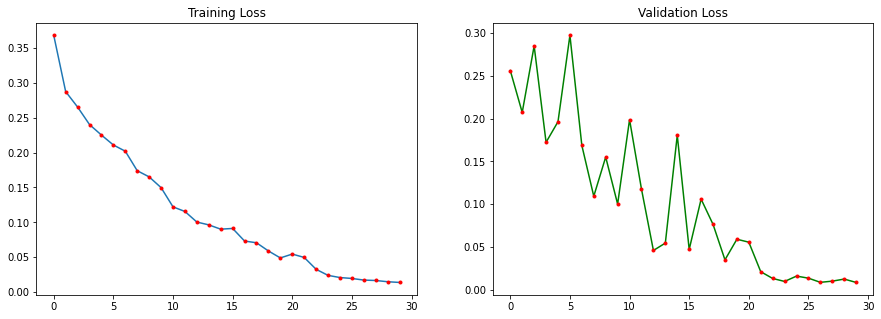

In [79]:
#Evaluate checking training & validation loss
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'],marker = '.',mec = 'r', mfc = 'r')

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'],marker = '.',mec = 'r', mfc = 'r',color="green")

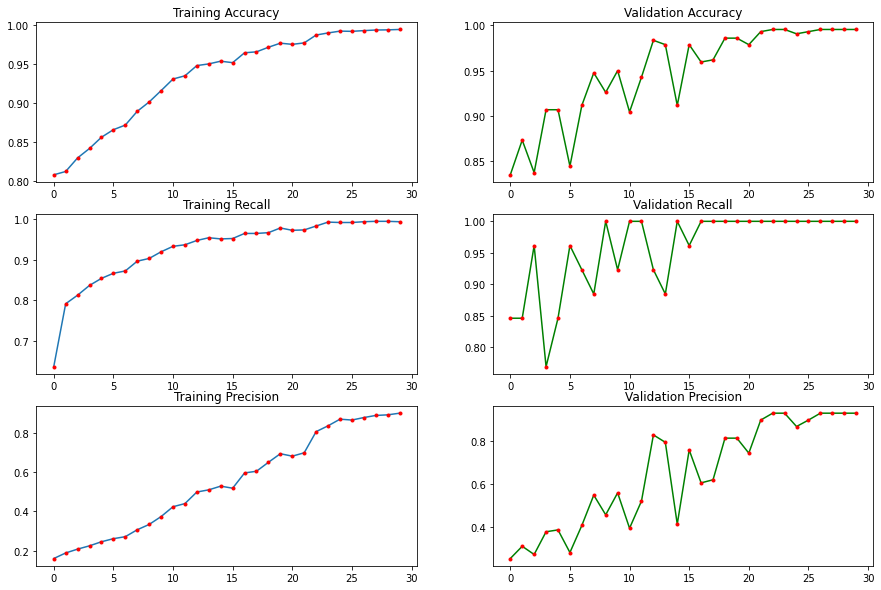

In [80]:
#Evaluate checking accuracy, recall and precision
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['binary_accuracy'],marker = '.',mec = 'r', mfc = 'r')

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_binary_accuracy'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['recall'],marker = '.',mec = 'r', mfc = 'r')

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_recall'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['precision'],marker = '.',mec = 'r', mfc = 'r')

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_precision'],marker = '.',mec = 'r', mfc = 'r',color="green")

In [81]:
#Evaluate checking recall

recall = history.history['recall'][-1]
precision = history.history['precision'][-1]

print('Train F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

recall = history.history['val_recall'][-1]
precision = history.history['val_precision'][-1]

print('Validation F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

Train F1 score: 0.9433
Validation F1 score: 0.9630


In [82]:
#predicting the model
predictions = model.predict([np.expand_dims(test_labels, axis=0), np.expand_dims(test_labels, axis=0)])

In [83]:
predictions

array([[8.0054786e-05]], dtype=float32)

### Evaluating with Live Inputs

In [84]:
#This is a function that takes a question and two possible answers (a positive and a negative) as inputs and predicts which of the two answers is more likely to be correct given the context of the question. 
def test_question(question, positive, negative):
    sentences = [question, positive, negative]
    
    #The function first pre-processes the input sentences (removes stop words and HTML tags) and then encodes them using the same tokenizer used for training the model. 
    for i in range(3):
        sentences[i] = remove_stopwords(sentences[i])
        sentences[i] = remove_html(sentences[i])
    
    sentences = encode(sentences, tokenizer)
    
    predictions = model.predict([np.expand_dims(sentences[1], axis=0), np.expand_dims(sentences[0], axis=0)])

    print('Positive: {0:.2f}'.format(predictions[0][0]))

    predictions = model.predict(
        [np.expand_dims(sentences[2], axis=0), np.expand_dims(sentences[0], axis=0)])

    #Finally, it passes the encoded sentences through the model and returns the predicted probability of the positive answer being correct and the predicted probability of the negative answer being correct.
    print('Negative: {0:.2f}'.format(predictions[0][0]))
    return predictions

In [85]:
question = 'who invented a portable handset '

positive='<P> Martin Cooper invented a portable handset in 1973, when he was a project manager at Motorola. It was almost three decades after the idea of cellular communications was introduced by Bell Laboratories. </P>'
negative = '<P> Email marketing has evolved rapidly alongside the technological growth of the 21st century . Prior to this growth , when emails were novelties to the majority of customers , email marketing was not as effective . In 1978 , Gary Thuerk of Digital Equipment Corporation ( DEC ) sent out the first mass email to approximately 400 potential clients via the Advanced Research Projects Agency Network ( ARPANET ) . This email resulted in $13 million worth of sales in DEC products , and highlighted the potential of marketing through mass emails . However , as email marketing developed as an effective means of direct communication , users began blocking out content from emails with filters and blocking programs . In order to effectively communicate a message through email , marketers had to develop a way of pushing content through to the end user , without being cut out by automatic filters and spam removing software . This resulted in the birth of triggered marketing emails , which are sent to specific users based on their tracked online browsing patterns . </P>'

In [86]:
test_question(question, positive, negative)

Positive: 0.02
Negative: 0.00


array([[0.00481182]], dtype=float32)

In [87]:
question = 'who is the south african high commissioner in london'

positive = "<P> Tracy McConnell , better known as `` The Mother '' , is the title character from the CBS television sitcom How I Met Your Mother . The show , narrated by Future Ted , tells the story of how Ted Mosby met The Mother . Tracy McConnell appears in 8 episodes from `` Lucky Penny '' to `` The Time Travelers '' as an unseen character ; she was first seen fully in `` Something New '' and was promoted to a main character in season 9 . The Mother is played by Cristin Milioti . </P>"

negative = "<P> In `` Bass Player Wanted '' , the Mother picks up a hitchhiking Marshall , carrying his son Marvin , on her way to Farhampton Inn . On their way , it is revealed that the Mother is a bass player in the band , that is scheduled to play at the wedding reception . But the band 's leader , Darren , forced her to quit . The Mother ultimately decides to confront Darren and retake the band . She ends up alone at the bar , and while practicing a speech to give Darren , Darren walks up to her furious the groom 's best man punched him for `` no reason . '' Amused by this , the Mother laughs , and Darren quits the band in anger . </P>"

In [88]:
test_question(question, positive, negative)

Positive: 1.00
Negative: 0.00


array([[1.9988289e-05]], dtype=float32)

## 9. **Part 2 - Extracting Short Answer from a Long Answer**

In [89]:
#filter records where short answers exists

# These functions are used to extract the short answer for a given long answer. get_short_answer extracts the start and end token positions of the short answer within the long answer. 

def get_short_answer(annotations, long_start, long_end):
    if len(annotations['short_answers']) > 0:
        short_start = annotations['short_answers'][0]['start_token']
        short_end = annotations['short_answers'][0]['end_token']        
        short_start = short_start - long_start
        short_end = short_end - long_start        
        return short_start, short_end
    else:
        return 0, 0
    
# form_short_data_row creates a new row in the data frame with the relevant information for the short answer.    
def form_short_data_row(question, text, long_start, long_end, short_start, short_end):
    long_answer = ' '.join(text[long_start:long_end])
    short_answer = ' '.join(long_answer.split(' ')[short_start:short_end])
    row = {
        'question': question,
        'long_answer': long_answer,
        'short_answer': short_answer,
        'short_start': short_start,
        'short_end': short_end
    }    
    return row

In [90]:
#loading short answers

#loads the short answer data for the given range of questions from a file, and creates a Pandas DataFrame with the question, long answer, short answer, short start, and short end for each row. 
def load_short_data(file_path, questions_start, questions_end):
    rows = []    
    with open(file_path) as file:

        #It first reads each line of the file, which is assumed to be in JSON format, and extracts the question, text, and annotations using the get_question_and_document() function. 
        for i in tqdm(range(questions_start, questions_end)):
            line = file.readline()
            line = json.loads(line)
            question, text, annotations = get_question_and_document(line)

            #Then, for each long answer candidate, it checks if the label is true using the get_long_candidate() function, and if so, extracts the short answer using the get_short_answer() function. 
            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True:
                    short_start, short_end = get_short_answer(annotations, long_start, long_end)
                    
                    #Finally, it creates a data row using form_short_data_row() and appends it to the list of rows.
                    rows.append(
                        form_short_data_row(question, text, long_start, long_end, short_start, short_end)
                    )
        
    return pd.DataFrame(rows)

In [91]:
train_short_df = load_short_data(train_path, 0, num_train_ques)
test_short_df = load_short_data(train_path, num_train_ques, num_val_ques)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [92]:
train_short_df.head(10)

,question,long_answer,short_answer,short_start,short_end
0,which is the most common use of opt-in e-mail ...,<P> A common example of permission marketing i...,a newsletter sent to an advertising firm 's cu...,8,17
1,how i.met your mother who is the mother,"<P> Tracy McConnell , better known as `` The M...",Tracy McConnell,1,3
2,what type of fertilisation takes place in humans,<P> The process of fertilization involves a sp...,,0,0
3,who had the most wins in the nfl,<P> Active quarterback Tom Brady holds the rec...,Tom Brady,3,5
4,who played mantis guardians of the galaxy 2,<P> Pom Klementieff ( born 3 May 1986 ) is a F...,Pom Klementieff,1,3
5,what indian tribe did the acadians form friend...,<P> The survival of the Acadian settlements wa...,,0,0
6,who is deputy cm of j and k,"<Table> <Tr> <Th_colspan=""2""> Deputy Chief Min...",,0,0
7,the nashville sound brought a polished and cos...,"<P> In the early 1960s , the Nashville sound b...",the use of lush string arrangements with a rea...,83,102
8,what channel is the premier league on in france,<Table> <Tr> <Th> Country </Th> <Th> Language ...,SFR Sport,223,225
9,what is the use of jdk in java,<P> The Java Development Kit ( JDK ) is an imp...,,0,0


In [93]:
count_values_in_column(train_short_df,'short_answer')

,Total,Percentage
,290,27.94
2018,4,0.39
2017,3,0.29
four,2,0.19
2008,2,0.19
...,...,...
from a band of armed guards called the Fighting Tigers of Columbia,1,0.10
Mark Lenard,1,0.10
Tipu Sultan,1,0.10
Nehwal,1,0.10


In [94]:
#encode the long answer and question text data for short answers using the tokenizer. 
#The encoded data will be used as input to the model for training and testing.
train_long_answers = encode(train_short_df['long_answer'].values, tokenizer)
train_questions = encode(train_short_df['question'].values, tokenizer)

test_long_answers = encode(test_short_df['long_answer'].values, tokenizer)
test_questions = encode(test_short_df['question'].values, tokenizer)

In [95]:
#define 2 arrays for the start index and another for the end index
def form_short_labels(df, sentence_length):
    start_labels = np.zeros((len(df), sentence_length))
    end_labels = np.zeros((len(df), sentence_length))

    #get the token indexes from short_start and short_end columns and assign it to new arrays. encoding with 1
    for i in range(len(df)):
        start = df.loc[i].short_start
        end = df.loc[i].short_end

        if start < 500 and end < 500:
            start_labels[i, start] = 1
            end_labels[i, end] = 1
        else:
            continue
    
    return start_labels, end_labels

train_start_labels, train_end_labels = form_short_labels(train_short_df, max_len)
test_start_labels, test_end_labels = form_short_labels(test_short_df, max_len)

In [96]:
#The code prints the question, long answer, short answer, start index, and end index of the 10th sample in the training set. 
print(train_short_df.loc[10].question)

print(train_short_df.loc[10].long_answer)
print(train_short_df.loc[10].short_answer)

#This can be useful for verifying the correctness of the data preprocessing and labeling.
print('Start index: {0}'.format(train_start_labels[10]))
print('End index: {0}'.format(train_end_labels[10]))

who needs to be in the car with a permit driver
<P> Typically , a driver operating with a learner 's permit must be accompanied by an adult licensed driver who is at least 21 years of age or older and in the passenger seat of the vehicle at all times . </P>
an adult licensed driver who is at least 21 years of age or older and in the passenger seat of the vehicle at all times
Start index: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 

## 10. Defining Model

In [97]:
# short answer model parameters
short_epochs = 100
short_batch_size = 64
embed_size_short=200

In [98]:
# load from file
embedding_dict = {}

with open('../input/glove6b/glove.6B.200' + 'd.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
        
f.close()

# write to matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, embed_size_short))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec
        
# load as tensorflow embedding
#define embedding layer for the short model
embedding_layer2 = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    embed_size_short,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [99]:
# encoding question input
question_input = Input(shape=(None,))
question_x = embedding_layer2(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(200, return_sequences=True))(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)

# encoding answer input
answer_input = Input(shape=(None,))
answer_x = embedding_layer2(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(250, return_sequences=True))(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)

# merge the encodings
combined_x = concatenate([question_x, answer_x])

# predict start index of the short answer
start_x = Dropout(0.1)(combined_x) 
start_x = Conv1D(1,1)(start_x)
start_x = Flatten()(start_x)
start_x = Activation('softmax', name='start_token')(start_x)

# predict end index of the short answer
end_x = Dropout(0.1)(combined_x) 
end_x = Conv1D(1,1)(end_x)
end_x = Flatten()(end_x)
end_x = Activation('softmax', name='end_token')(end_x)

# merge the parts into one model
short_model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=[start_x, end_x])

In [100]:
short_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['categorical_accuracy', 'Recall', 'Precision'])

In [101]:
short_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    13415200    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, None, 200)    0           embedding_1[0][0]          

In [102]:
# define callbacks for the short model
#increased patience or number of epochs with no improvement after which training will be stopped.
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=4, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),]

In [103]:
history = short_model.fit(
    x = [train_long_answers, train_questions], 
    y = [train_start_labels, train_end_labels],epochs = short_epochs, callbacks = callbacks,
    validation_data = ([test_long_answers, test_questions], [test_start_labels, test_end_labels]),
    batch_size = short_batch_size,  shuffle = True)

Epoch 1/100
17/17 [==============================] - 24s 550ms/step - loss: 8.8698 - start_token_loss: 4.3275 - end_token_loss: 4.5424 - start_token_categorical_accuracy: 0.1667 - start_token_recall: 0.0000e+00 - start_token_precision: 0.0000e+00 - end_token_categorical_accuracy: 0.1455 - end_token_recall_1: 0.0000e+00 - end_token_precision_1: 0.0000e+00 - val_loss: 7.5077 - val_start_token_loss: 3.5886 - val_end_token_loss: 3.9191 - val_start_token_categorical_accuracy: 0.3462 - val_start_token_recall: 0.0769 - val_start_token_precision: 0.3333 - val_end_token_categorical_accuracy: 0.3462 - val_end_token_recall_1: 0.0000e+00 - val_end_token_precision_1: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 7s 400ms/step - loss: 7.7403 - start_token_loss: 3.7654 - end_token_loss: 3.9749 - start_token_categorical_accuracy: 0.3025 - start_token_recall: 0.0069 - start_token_precision: 0.1556 - end_token_categorical_accuracy: 0.3025 - end_token_recall_1: 0.0030 - end_token_precis

In [104]:
short_model.save('short_model.h5')

## 11. **Model Evaluation**

### Identifying if correct short answers given to a long answers

In [105]:
#printing the final epoch number and the corresponding training loss value from the history object returned by the fit() method of the model. 
#It can be used to monitor the training progress of the model and to ensure that the model is improving with each epoch.
print('Epoch: {0}'.format(len(history.history['loss'])))
print('Loss: {0}'.format(history.history['loss'][-1]))

Epoch: 31
Loss: 2.6512441635131836


In [106]:
#Training Results
print('Training final results')

accuracy = history.history['start_token_categorical_accuracy'][-1]
recall = history.history['start_token_recall'][-1]
precision = history.history['start_token_precision'][-1]

print('--------------------------------------------------')
print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

print('--------------------------------------------------')

accuracy = history.history['end_token_categorical_accuracy'][-1]
recall = history.history['end_token_recall_1'][-1]
precision = history.history['end_token_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

Training final results
--------------------------------------------------
Start token accuracy: 0.6406551003456116
Start token recall: 0.5384615659713745
Start token precision: 0.8465116024017334
Start token F1 score: 0.6582
--------------------------------------------------
End token accuracy: 0.6252408623695374
End token recall: 0.5394477248191833
End token precision: 0.8091716170310974
End token F1 score: 0.6473


In [107]:
#Validation results
print('Validation final results')
print('--------------------------------------------------')

accuracy = history.history['val_start_token_categorical_accuracy'][-1]
recall = history.history['val_start_token_recall'][-1]
precision = history.history['val_start_token_precision'][-1]

print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format( 2 * (precision * recall) / (precision + recall)))

print('--------------------------------------------------')

accuracy = history.history['val_end_token_categorical_accuracy'][-1]
recall = history.history['val_end_token_recall_1'][-1]
precision = history.history['val_end_token_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(2 * (precision * recall) / (precision + recall)))

Validation final results
--------------------------------------------------
Start token accuracy: 0.7692307829856873
Start token recall: 0.6538461446762085
Start token precision: 0.9444444179534912
Start token F1 score: 0.7727
--------------------------------------------------
End token accuracy: 0.7307692170143127
End token recall: 0.6153846383094788
End token precision: 1.0
End token F1 score: 0.7619


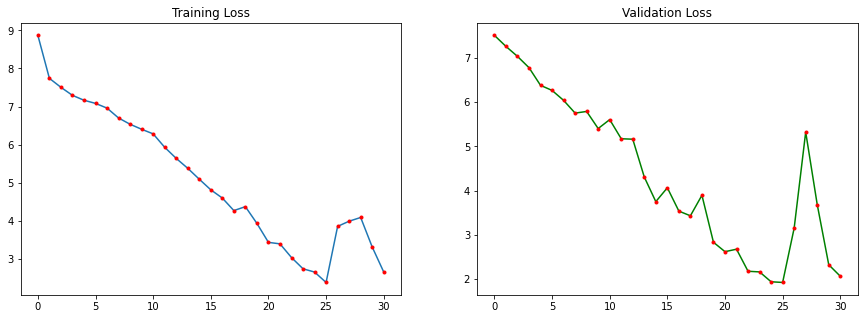

In [108]:
#Evaluate plotting training & validation loss

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'],marker = '.',mec = 'r', mfc = 'r')

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'],marker = '.',mec = 'r', mfc = 'r',color="green")


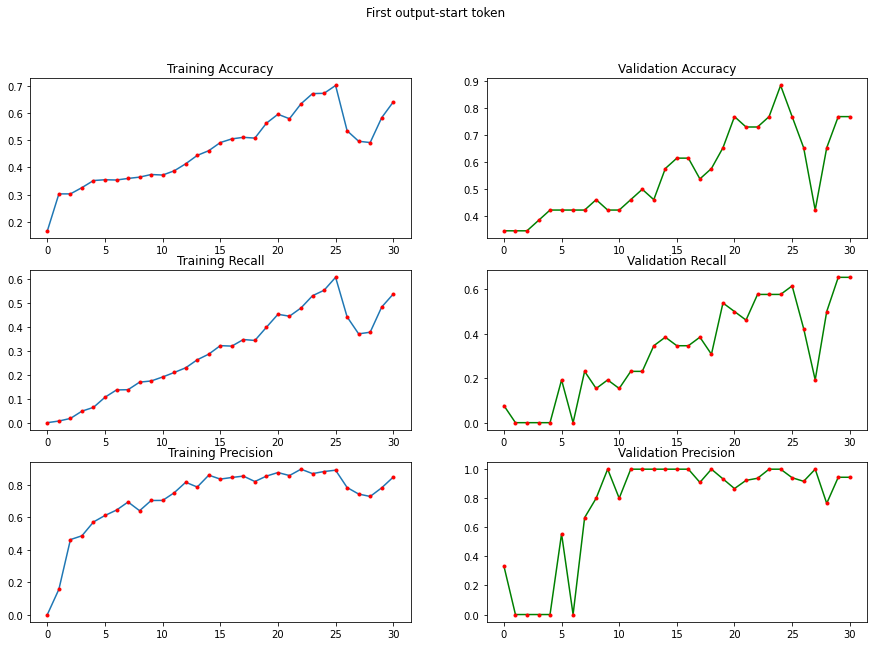

In [109]:
#plotting metrics; accuracy, precision, recall for the first output array
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('First output-start token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['start_token_categorical_accuracy'],marker = '.',mec = 'r', mfc = 'r')

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_start_token_categorical_accuracy'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['start_token_recall'],marker = '.',mec = 'r', mfc = 'r')

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_start_token_recall'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['start_token_precision'],marker = '.',mec = 'r', mfc = 'r')

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_start_token_precision'],marker = '.',mec = 'r', mfc = 'r',color="green")

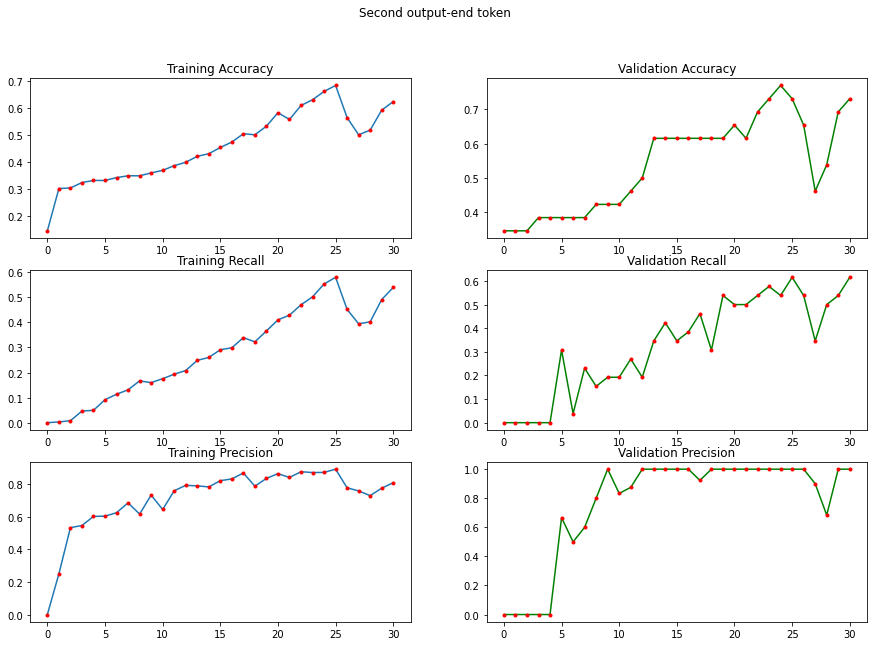

In [110]:
#plotting metrics; accuracy, precision, recall for the second output array
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('Second output-end token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['end_token_categorical_accuracy'],marker = '.',mec = 'r', mfc = 'r')

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_end_token_categorical_accuracy'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['end_token_recall_1'],marker = '.',mec = 'r', mfc = 'r')

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_end_token_recall_1'],marker = '.',mec = 'r', mfc = 'r',color="green")

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['end_token_precision_1'],marker = '.',mec = 'r', mfc = 'r')

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_end_token_precision_1'],marker = '.',mec = 'r', mfc = 'r',color="green")

### Testing with Live Inputs

In [111]:
# This is a function that takes a question and a long answer as input and returns the predicted start index, end index, and predicted short answer string based on the trained short_model. 
# The function first encodes the input question and long answer using the same tokenizer used during training. 

def test_short_answer(question, long_answer):
    sentences = [long_answer, question]
    
    sentences = encode(sentences, tokenizer)
    
    predictions = short_model.predict(
        [np.expand_dims(sentences[0], axis=0), np.expand_dims(sentences[1], axis=0)])
    
    predictions = np.array(predictions)

#Then, it passes the encoded sequences through the short_model to obtain the predicted start and end positions for the short answer. 
#Finally, it extracts the predicted short answer string based on the predicted start and end indices of the short answer from the long answer.
    prediction_start = np.argmax(predictions[0,0])
    prediction_end = np.argmax(predictions[1,0])
    prediction_string = ' '.join(long_answer.split(' ')[prediction_start:prediction_end])

    return prediction_start, prediction_end, prediction_string

In [112]:
question = 'which is the most common use of opt-in e-mail marketing'
long_answer = "<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>"

In [113]:
start, end, short_answer = test_short_answer(question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

Start token: 9
End token: 16
Answer: newsletter sent to an advertising firm 's


In [114]:
question = 'who invented a portable handset'
long_answer="<P> Martin Cooper invented a portable handset in 1973, when he was a project manager at Motorola. It was almost three decades after the idea of cellular communications was introduced by Bell Laboratories. </P>"

In [115]:
start, end, short_answer = test_short_answer(question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

Start token: 0
End token: 3
Answer: <P> Martin Cooper


In [116]:
question = 'who is the south african high commissioner in london'
long_answer = "<P> Tracy McConnell , better known as `` The Mother '' , is the title character from the CBS television sitcom How I Met Your Mother . The show , narrated by Future Ted , tells the story of how Ted Mosby met The Mother . Tracy McConnell appears in 8 episodes from `` Lucky Penny '' to `` The Time Travelers '' as an unseen character ; she was first seen fully in `` Something New '' and was promoted to a main character in season 9 . The Mother is played by Cristin Milioti . </P>"

In [117]:
start, end, short_answer = test_short_answer(question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

Start token: 1
End token: 3
Answer: Tracy McConnell


## 12. End Notes

In this project, we have demonstrated how to use TensorFlow 2.0 to build a model that can answer user questions about Wikipedia page content. We have used the Natural Questions dataset to train and evaluate the model.

The project is divided into two parts. In **Part 1**, we focused on **identifying the correct long answer to a question**. We pre-processed the text data, defined the embedding layer using GloVe, and built a model using TensorFlow 2.0. We also evaluated the model and obtained good results.

In **Part 2**, we focused on **extracting the short answer from a long answer**. We defined a separate model for this purpose, which takes the long answer and question as input and predicts the start and end positions of the short answer. We also evaluated this model and obtained good results.

Overall, this project demonstrates the power of deep learning and TensorFlow 2.0 in answering real-world questions using natural language processing. The techniques used in this project can be extended to other applications such as chatbots, virtual assistants, and customer service support.

**Thank you!**